In [10]:
import MixedVariableObjectiveFunctions as f_mixed
from MixedVariableObjectiveFunctions import setC
import ellipsoidFunctions as Efunc
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random

In [11]:
def OnePlusOneEvolutionStrategy(n, lb, ub, maxEvals, func=lambda x: x.dot(x), fstop=0, seed=None, record_interval=50):
    """
    @author: ofersh@telhai.ac.il
    (1+1)-Evolution Strategy with the 1/5th success-rule initialized within [lb,ub]**n
    The objective function evaluation calls are adjusted to the ObjectiveFunctoin interface.
    """
    local_state = np.random.RandomState(seed)
    fhistory, shistory = [], []
    xmin = local_state.uniform(size=n) * (ub - lb) + lb
    # Evaluate and store fitness as a scalar
    fmin = func(xmin.reshape(1, -1))
    fmin = fmin.item() if hasattr(fmin, "item") else fmin
    fhistory.append(fmin)
    sigma = (ub - lb) / 6.0
    shistory.append(sigma)
    evalcount, osuccess = 0, 0
    tol = 1e-6
    epoch = 50
    k_sigma = 0.827

    while (evalcount < maxEvals and fmin > fstop + tol):
        x = xmin + sigma * local_state.normal(size=n)
        f_x = func(x.reshape(1, -1))
        f_x = f_x.item() if hasattr(f_x, "item") else f_x
        evalcount += 1
        if f_x < fmin:
            xmin = np.copy(x)
            fmin = f_x
            osuccess += 1

        if (np.mod(evalcount, epoch) == 0):
            ps = osuccess / epoch
            if ps < 0.2:
                sigma *= k_sigma
            elif ps > 0.2:
                sigma /= k_sigma
            osuccess = 0
            if evalcount % record_interval == 0:
                fhistory.append(fmin)
                shistory.append(sigma)

        if evalcount % record_interval == 0:
            fhistory.append(fmin)
            shistory.append(sigma)

    return xmin, fmin, fhistory, shistory


def gaussian_mutation(x, lb, ub, int_indices, sigma=5):
    """
    @author: ChatGPT
    Applies Gaussian mutation to integer variables.
    """
    x_new = np.copy(x)
    for i in int_indices:
        step = int(np.random.normal(0, sigma))  # Gaussian step as an integer
        x_new[i] = np.clip(x[i] + step, lb, ub)
    return x_new


def optimize_integer_part(xreal, lb, ub, n, max_evals, func):
    """
    Optimizes the integer part using a combination of regular and jump mutations.
    If no improvement is seen for a number of iterations, a dynamic Gaussian jump is applied.
    """
    xint = np.round(xreal[n:]).astype(int)
    candidate = np.concatenate([xreal[:n], xint]).reshape(1, -1)
    best_fitness = func(candidate)
    best_fitness = best_fitness.item() if hasattr(best_fitness, "item") else best_fitness
    best_xint = xint.copy()

    evalcount = 0
    stuck_count = 0
    stuck_threshold = 20  # if no improvement for 20 iterations, consider it stuck
    jump_sigma = 10    # initial jump sigma
    k_down = 0.9       # decrease factor if jump is successful
    k_up = 1.1         # increase factor if jump is not successful

    while evalcount < max_evals:
        mutated_xint = np.copy(xint)
        for i in range(len(mutated_xint)):
            if random.random() < 0.3:
                mutated_xint = gaussian_mutation(mutated_xint, lb, ub, [i])
        candidate = np.concatenate([xreal[:n], mutated_xint]).reshape(1, -1)
        fmutated = func(candidate)
        fmutated = fmutated.item() if hasattr(fmutated, "item") else fmutated
        evalcount += 1

        if fmutated < best_fitness:
            best_fitness = fmutated
            best_xint = mutated_xint.copy()
            xint = mutated_xint.copy()
            stuck_count = 0
        else:
            stuck_count += 1

        if stuck_count >= stuck_threshold:
            # print("Integer part stuck. Performing dynamic Gaussian mutation jump with sigma =", jump_sigma)
            jump_mutated = gaussian_mutation(xint, lb, ub, list(range(len(xint))), sigma=jump_sigma)
            candidate = np.concatenate([xreal[:n], jump_mutated]).reshape(1, -1)
            new_fitness = func(candidate)
            new_fitness = new_fitness.item() if hasattr(new_fitness, "item") else new_fitness
            evalcount += 1

            if new_fitness < best_fitness:
                best_fitness = new_fitness
                best_xint = jump_mutated.copy()
                xint = jump_mutated.copy()
                jump_sigma *= k_down  # decrease sigma for a finer jump next time
            else:
                jump_sigma *= k_up    # increase sigma to try a larger jump
            stuck_count = 0  # reset stuck counter

    return best_xint, best_fitness


def optimize_real_part(func, lb, ub, dim, max_evals, record_interval=50):
    xmin, fmin, fhistory, shistory = OnePlusOneEvolutionStrategy(dim, lb, ub, max_evals, func=func, record_interval=record_interval)
    return xmin, fmin, fhistory, shistory


def optimize_combined(func, lb, ub, dim, max_evals, record_interval=50):
    real_part, fmin_real, fhistory, shistory = optimize_real_part(func, lb, ub, dim, max_evals, record_interval=record_interval)
    n = dim // 2
    integer_part, fmin_integer = optimize_integer_part(real_part, lb, ub, n, max_evals, func=func)
    optimized_solution = np.concatenate([real_part[:n], integer_part])
    return optimized_solution, fmin_integer, fhistory

In [ ]:
lb, ub = -100, 100
dim = 64
N = dim // 2
setC(N)
c = 100
maxEvals = 100000
NRUNS = 30
X = np.full((3 * NRUNS, dim + 2), np.nan)
plt.figure(figsize=(12, 6))
objFunc = "MixedVarsEllipsoid"

for index, funcName in enumerate(['genHcigar', 'genRotatedHellipse', 'genHadamardHellipse']):
#for index, funcName in enumerate(['genHadamardHellipse']):
    H = eval(f'Efunc.{funcName}')(dim, c)
    f = eval(f'f_mixed.{objFunc}')(d=dim, bid=0, ind=N, H=H, c=c, max_eval=maxEvals)

    function_histories = []  # Store all runs for averaging
    print(f"**************************{funcName}**************************")
    for k in range(NRUNS):
        optimized_solution, fmin, fhistory = optimize_combined(func=f, lb=lb, ub=ub, dim=dim, max_evals=maxEvals)
        print(f"{funcName} | Run {k + 1}: Best Combined Fitness = {fmin} | Best solution = {optimized_solution}")
        function_histories.append(fhistory)
    print(f"**************************{funcName}**************************\n")

    max_length = max(len(history) for history in function_histories)
    uniform_histories = np.array([
        np.pad(history, (0, max_length - len(history)), mode='edge')  # Pad with last value
        if len(history) < max_length else history[:max_length]  # Truncate if too long
        for history in function_histories
    ])
    # Convert to numpy array for averaging
    function_histories = np.array(uniform_histories)
    function_histories = np.squeeze(function_histories)
    # Compute mean and standard deviation across runs
    mean_fitness = np.mean(function_histories, axis=0)
    std_fitness = np.std(function_histories, axis=0)

    # Plot the mean fitness curve
    plt.plot(mean_fitness, label=f"{funcName} (Mean Fitness)", linewidth=2.5)
    # Ensure correct shape before proceeding
    if function_histories.ndim != 2:
        raise ValueError(f"function_histories has incorrect shape: {function_histories.shape}")
    # Add a confidence interval (shaded area)
    plt.fill_between(range(len(mean_fitness)), mean_fitness - std_fitness, mean_fitness + std_fitness,
                     alpha=0.2)

**************************genHcigar**************************
genHcigar | Run 1: Best Combined Fitness = 9.999562892974397e-07 | Best solution = [ 6.99004922 -6.99999379  7.00004008 -6.99999574  6.99998313 -7.00000288
  7.00000751 -6.99998812  7.0000219  -6.99998298  6.99998903 -7.00000052
  7.00000368 -7.00004047  7.00001184 -6.99999369  7.00002177 -7.00001688
  6.99998412 -7.00000506  6.9999967  -6.9999716   6.99997774 -7.00000545
  6.99997135 -6.99997577  7.00002101 -7.00000223  7.00000967 -6.99999748
  6.99998352 -6.99998276  7.         -7.          7.         -7.
  7.         -7.          7.         -7.          7.         -7.
  7.         -7.          7.         -7.          7.         -7.
  7.         -7.          7.         -7.          7.         -7.
  7.         -7.          7.         -7.          7.         -7.
  7.         -7.          7.         -7.        ]
genHcigar | Run 2: Best Combined Fitness = 5.000000000027578 | Best solution = [ 7.00005211 -6.99999994  7.00000004

C:\Users\malia\AppData\Local\Temp\ipykernel_18780\2300515978.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=9, frameon=False)


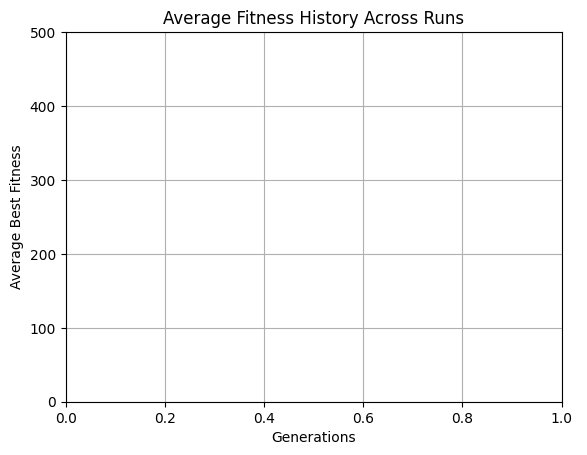

In [6]:
plt.xlabel("Generations")
plt.ylabel("Average Best Fitness")
plt.title("Average Fitness History Across Runs")
plt.grid(True)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=9, frameon=False)
plt.show()